# GBIF_Request
<!-- ## Responsabilities of this file
 

*  Request data from the specific species on GBIF
*  Show species occurrences locations 
*  Show main statistics about those occurrences -->

## Todo
* Lear o JSON da espécie estudada e fazer arequisição de todas as espécies contidas no mesmo

## Who is Running?

In [8]:
#Matheus
project_root = "/content/drive/MyDrive/Mestrado/Deep Learning/Projeto"
#Gabi
#Jean
#Sandra

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## General Parâmeters

In [9]:
# General parameters
study_case_name = "Anodorhynchus_hyacinthinus" #@param {type:"string"}

Fixed Parameters

In [10]:
# Required parametes to instantiate Specie
limit = 300
hasCoordinate=True
lowYear=2000
upYear=2020
dropDuplicates=True
tryOverrideSpecieData=True
result_gibf_queries_maps_root_folder = project_root+'/Data/GBIF_Ocurrences_Maps'
result_gibf_queries_data_root_folder =project_root+'/Data/GBIF_Ocurrences'

# Required parametes to instantiate Brazil
country_shapefiles_folder = project_root+'/Data/Shapefiles/Shapefiles_Brasil'
Country_limits = (-73.981934,-34.792929, -33.750035, 5.271478)

#Study Case Path
study_cases_root_folder = project_root+"/Data/Study_Cases"

## Installations

In [11]:
!pip install pygbif --quiet
!pip install geopandas --quiet

## Retrieving aux Classes

In [12]:
!wget https://raw.githubusercontent.com/math-sasso/extinction-prevention-modeling-MO434/main/Aux_Files/utils.py

--2020-12-14 18:29:18--  https://raw.githubusercontent.com/math-sasso/extinction-prevention-modeling-MO434/main/Aux_Files/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 800 [text/plain]
Saving to: ‘utils.py.1’

utils.py.1          100%[===================>]     800  --.-KB/s    in 0s      

2020-12-14 18:29:18 (40.6 MB/s) - ‘utils.py.1’ saved [800/800]



In [13]:
from utils import Utils
utils_methods = Utils()

## Getting Specie Study Data

In [14]:
import pandas as pd
import os
study_case_path =  os.path.join(study_cases_root_folder,study_case_name +'.csv')
study_information_df = pd.read_csv(study_case_path)
study_information_df

,GBIF_ID,Species_Name,Study_Focus
0,2479359,Anodorhynchus hyacinthinus,True
1,2732686,Attalea maripa,False
2,7413879,Acrocomia aculeata,False
3,2732758,Attalea phalerata,False


In [15]:
species_name = study_information_df[study_information_df['Study_Focus'] ==True]['Species_Name'][0]
taxonKey = study_information_df[study_information_df['Study_Focus'] ==True]['GBIF_ID'][0]
species_name_string = species_name.replace(" ","_")
print(f"species_name: {species_name} \ntaxonKey: {taxonKey} \nspecies_name_string: {species_name_string} \n ")

species_name: Anodorhynchus hyacinthinus 
taxonKey: 2479359 
species_name_string: Anodorhynchus_hyacinthinus 
 


## Classe CountryShapefile

In [16]:
%%writefile brazil.py
import os
from osgeo import ogr
from shapely import wkt
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
from typing import Tuple


class Brazil:
  """
  This class models a country on the shapefile format on different detail levels
  
  
  Attributes
  ----------
  x_min_limit : float
      Country most western point
  x_max_limit : float
      Country most eastern point
  y_min_limit : float
      Country most south point
  y_max_limit : float
      Country most north point
  _brazil_country_level_gpd : GeoDataframe
      Geopandas dataframe for brazilian territory as country
  _brazil_state_level_gpd : GeoDataframe
      Geopandas dataframe for brazilian territory as states
  _brazil_city_level_gpd : GeoDataframe
      Geopandas dataframe for brazilian territory as cities
  _brazil_district_level_gpd : GeoDataframe
      Geopandas dataframe for brazilian territory as districts
  _brazil_country_level_path : str
      Path to brazilian territory as country
  _brazil_state_level_path : str
      Path to brazilian territory as states
  _brazil_city_level_path : str
      Path to brazilian territory as cities
  _brazil_district_level_path : str
      Path to brazilian territory as districts

  
  """


  def __init__(self, shapefiles_folder:str,country_limits:Tuple):
    """
    Parameters
    ----------
    shapefiles_folder : str
        Folder cointaing shapefiles from some country
    country_limitsr : Tuple
        Tuple with the country 4 limits (N,S,L,W)
    """

    #Country_Limits
    self.x_min_limit = country_limits[0]  # Coordenadas DMS: 07°32′39″S 073°59′04″W; Coordenada Decimal Geohack: -7.544167, -73.984444; Corrdenada Decimal epsg.io: -7.535403, -73.981934
    self.x_max_limit = country_limits[1]  # Coordenadas DMS: 07°09′28″S 034°47′38″W; Coordenada Decimal Geohack: -20.474444, -28.840556; Corrdenada Decimal epsg.io: -7.155017, -34.792929
    self.y_min_limit = country_limits[2]  # Coordenadas DMS: 33°45′09″S 053°22′07″W; Coordenada Decimal Geohack: -33.7525, -53.368611; Corrdenada Decimal epsg.io: -33.750035, -53.407288
    self.y_max_limit = country_limits[3]  # Coordenadas DMS: 05°15′05″N 060°12′33″W; Coordenada Decimal Geohack: 5.251389, -60.209167; Corrdenada Decimal epsg.io: 5.271478, -60.214691
      
    #Folder
    brazil_country_level_folder = shapefiles_folder + '/Pais'
    brazil_state_level_folder = shapefiles_folder + '/Estados'
    brazil_city_level_folder = shapefiles_folder + '/Municipios'
    brazil_district_level_folder = shapefiles_folder + '/Distritos'
    
    #Complete file path
    self._brazil_country_level_path = os.path.join(brazil_country_level_folder, 'BRA_adm0.shp')
    self._brazil_state_level_path = os.path.join(brazil_state_level_folder, 'BRA_adm1.shp')
    self._brazil_city_level_path = os.path.join(brazil_city_level_folder, 'BRA_adm2.shp')
    self._brazil_district_level_path = os.path.join(brazil_district_level_folder, 'BRA_adm3.shp')

    # GeoDataFrame
    self._brazil_country_level_gpd = gpd.read_file(self._brazil_country_level_path)
    self._brazil_state_level_gpd = gpd.read_file(self._brazil_state_level_path)
    self._brazil_city_level_gpd = gpd.read_file(self._brazil_city_level_path)
    self._brazil_district_level_gpd = gpd.read_file(self._brazil_district_level_path)


  def get_country_level_gdf(self):
    """Construct geopandas dataframe for brazilian territory as country"""
    return self._brazil_country_level_gpd

  def get_state_level_gdf(self):
    """Construct geopandas dataframe for brazilian territory as states"""
    return self._brazil_state_level_gpd

  def get_city_level_gdf(self):
    """Construct geopandas dataframe for brazilian territory as cities"""
    return self._brazil_city_level_gpd

  def get_district_level_gdf(self):
    """Construct geopandas dataframe for brazilian territory as disrticts"""
    return self._brazil_district_level_gpd

  def get_df_only_with_inside_country_points(self,df,name_index:str='NAME_ISO',country_index:str='COUNTRY',lat_index:str='LATITUDE',lon_index:str='LONGITUDE'):
    """
    Returns a filtered df without the missmarked occurrences, checking if they realy are inside the country

    Parameters
    ----------
    df : Dataframe
        Dataframe with gbif occurenced not checked
    name_index : str
        Column with name information 
    country_index : str
        Column with country information  
    lat_index : str
        Column with latitude information
    lon_index : str
        Column with longitude information
    """

    # 1 --> Open shapefile containing country polygons
    filename = self._brazil_country_level_path
    drv = ogr.GetDriverByName('ESRI Shapefile')                # set up driver object to read/write shapefiles        
    shapefile = drv.Open(filename)                             # open shapefile 
    layer = shapefile.GetLayer(0)                              # create layer object for shapefile                               
    
    #2 --> Determine indices of relevant columns
    nameIndex = layer.GetLayerDefn().GetFieldIndex(name_index) # index of column with country names in shapefile 
    countryIndex = df.columns.get_loc(country_index)           # index of country name column in observation table                                                            
    latIndex = df.columns.get_loc(lat_index)                   # index of lat column in observation table
    lonIndex = df.columns.get_loc(lon_index)                   # index of lon column in observation table

    #3 --> Countries Check.
    geocodingResults = []  #Set up list in which we will store the results of looking up the containing country for each row

    # itertuples is used to efficiently loop through the rows of the data frame
    for row in df.itertuples(index=False):  

        # create a new OGR point object with lon and lat coordinates from current row 
        pt = ogr.Geometry(ogr.wkbPoint)                    
        pt.SetPoint_2D(0, row[lonIndex], row[latIndex] )  

        # apply spatial filter that will give us polygons that intersect our point
        layer.SetSpatialFilter(pt)                         

        country = "UNKNOWN"# variable for storing the country's name

        # check whether there's exactly one feature selected, if get country name of that feature
        if layer.GetFeatureCount() == 1:                   
            country = layer.GetNextFeature().GetFieldAsString(nameIndex).title()
        
        # add country name to result list
        geocodingResults.append(country)                   
    
    df['country_geocoding'] = geocodingResults  # add geocoding results as new column
    df = df [(df.country_geocoding == df.COUNTRY)|(df.country_geocoding == 'Brazil')]


    #4 --> Limits Check.
    df = df[df['LONGITUDE']>=self.x_min_limit]
    df = df[df['LONGITUDE']<=self.x_max_limit]
    df = df[df['LATITUDE']>=self.y_min_limit]
    df = df[df['LATITUDE']<=self.y_max_limit]
    return df


  def plot_points_on_country(self,
                              species_name:str,
                              map_result_path:str,
                              species_presences_path:str,
                              species_absences_path:str=None):
                              
    fig, ax = plt.subplots(figsize=(10, 10))

    self._brazil_country_level_gpd.plot(ax=ax, facecolor='gray')



    if ".csv" in species_presences_path:
      df_species_presences = pd.read_csv(species_presences_path)
      gdf_species_presences = gpd.GeoDataFrame(df_species_presences, geometry=gpd.points_from_xy(df_species_presences.LONGITUDE, df_species_presences.LATITUDE),crs='epsg:4326')
      # df_species_presences['geometry'] = df_species_presences['geometry'].apply(wkt.loads)
      # gdf_species_presences = gpd.GeoDataFrame(df_species_presences, crs='epsg:4326')
    elif ".shp" in species_presences_path:
      gdf_species_presences = gpd.read_file(species_presences_path)
    gdf_species_presences.plot(ax=ax, color='blue', markersize=5,label="presences")
    
    if species_absences_path:
      if ".csv" in species_absences_path:
        df_species_absences = pd.read_csv(species_absences_path)
        gdf_species_absences = gpd.GeoDataFrame(df_species_absences, geometry=gpd.points_from_xy(df_species_absences.LONGITUDE, df_species_absences.LATITUDE),crs='epsg:4326')
      elif ".shp" in species_absences_path:
        gdf_species_absences = gpd.read_file(species_absences_path)
      gdf_species_absences.plot(ax=ax, color='red', markersize=5,label="absences")
      plt.title(f'Ocorrências e Abeências da espécie \n {species_name} no Brasil',fontsize=20)
    else:
      plt.title(f'Ocorrências da espécie  \n {species_name} no Brasil',fontsize=20)
    
    plt.ylabel('Latitude [graus]',fontsize=16)
    plt.xlabel('Longitude [graus]',fontsize=16)
    plt.tight_layout()
    plt.savefig(map_result_path)



Writing brazil.py


In [17]:
%run brazil.py

## Classe Genérica para fazer a requisição
Alguns outros parâmtreos interessantes que podem ser considerados 
elevation: Elevation (altitude) in meters above sea level. Supports range queries.
establishmentMeans: EstablishmentMeans, as defined in our EstablishmentMeans enum
repatriated: Searches for records whose publishing country is different to the country where the record was recorded in.

In [18]:
%%writefile specie.py
import requests
import pandas as pd
import os
import geopandas as gpd
import numpy as np

class Specie:

  """
  This class reprepsents a specie that is retrieved from GBIF

   Attributes
  ----------
  _taxonKey : int
      GBIF code for requesting species data
  _species_name : string
      Species cientific name
  _limit : int
      Limit of rows by request
  _hasCoordinate : boolean
      Boolean for getting only data with Lat and Long
  _lowYear : int
      Low year limit for the query 
  _upYear : int
      UP year limit for the query
  _year_range : int
      Geopandas dataframe for brazilian territory as cities
  _dropDuplicates : boolean
      True for dropping duplicate occurrences
  _tryOverrideSpecieData : boolean
      True for always retrieve the shapefile, false to used an existing one
  _base_url : string
       GBIF base URL
  _out_shapefile_parent_folder : string
      Path with shapefiles saving location

  """
  def __init__(self,
               taxonKey:int,
               species_name:str,
               countryObj:object=None,
               limit:int =300,
               hasCoordinate: bool=True,
               lowYear:int=None,
               upYear:int=None,
               dropDuplicates:bool=True,
               tryOverrideSpecieData:bool=False,
               base_url:str = "http://api.gbif.org/v1/occurrence/search",
               out_shapefile_parent_folder:str=None):
    
    """    
    Parameters
    ----------
    taxonKey : int
        GBIF taxonkey identifier
    species_name : str
        Species Name
    countryObj : object
        Object with country shapefiles
    limit : int
        Limit of occurences in one request 
    hasCoordinate : bool
        True for only get occurences with coordinates
    lowYear : int
        Low Year occurrence limit
    upYear : int
        Up Year occurrence limit
    dropDuplicates : bool
        True for dropping duplicate occurrences
    tryOverrideSpecieData : bool
        True for always retrieve the shapefile, false to used an existing one
    base_url : str
        GBIF base URL
    out_shapefile_parent_folder : str
        Path with shapefiles saving location
        
    """
    
    #-------Country Object
    self._countryObj = countryObj

    #--------Parameters
    self._taxonKey = taxonKey
    self._species_name = species_name
    self._limit = limit
    self._hasCoordinate = hasCoordinate
    self._lowYear = lowYear
    self._upYear = upYear
    self._year_range = str(lowYear) + ',' +str(upYear)
    self._dropDuplicates = dropDuplicates
    self._tryOverrideSpecieData = tryOverrideSpecieData
    self._base_url = base_url
    self._out_shapefile_parent_folder = out_shapefile_parent_folder

    #--------Data Retrieval
    if (not self._tryOverrideSpecieData) and (self._data_reader()):
      print("In this case GBIF request was not necessary, we got gdf from Shapefile")
      self._df = None
      self._gdf = self._data_reader()
    else:
      print("In this case GBIF request was necessary to create gdf file")
      df_dirty = self._managing_complete_species_dataframe()
      self._df = self._get_inside_country_dataframe(df_dirty)
      self._gdf = self._create_specie_geo_dataframe()
      print('Effectively ' + str(len(self._gdf)) + ' examplars are inside country boarders')
      self._shp_exporter()
      

  #-------- Private Methods 
  def _managing_complete_species_dataframe(self):
    """ Organizes GBIF information in a dataframe considering offsets and some basic data cleaning"""

    df = pd.DataFrame(columns=['GBIF_ID','SCIENTIFIC_NAME','LONGITUDE','LATITUDE','COUNTRY','STATE_PROVINCE','IDENTIFICATION_DATE','DAY','MONTH','YEAR'])
    endOfRecords = False  
    offset = 0  
    status = 200
    params = {'taxonKey': str(self._taxonKey) ,'limit':self._limit,'hasCoordinate':self._hasCoordinate,'year':self._year_range,'country':'BR'} 
    while endOfRecords == False and status == 200:  
        r, endOfRecords, status = self._gbif_request_json_request(offset, params)
        df = self._create_specie_dataframe(df,r)
        offset = len(df) + 1
    
    # Double check to certify there is no empty lat/long data
    df = df[pd.notnull(df['LATITUDE'])]
    df = df[pd.notnull(df['LONGITUDE'])]

    # Removing duplicate data
    df = df.drop_duplicates(ignore_index=True) if self._dropDuplicates else df

    # Sorting Data by STATE_PROVINCE
    df.sort_values("STATE_PROVINCE", inplace = True,ignore_index=True)
    return df

  def _gbif_request_json_request(self,offset,params):
    """ Request GBIF information """

    query = self._base_url
    params['offset'] = offset
    r = requests.get(query,params=params)
    status_code =  r.status_code
    if r.status_code != 200:  
        print(f"API call failed at offset {offset} with a status code of {r.status_code}.") 
        endOfRecords = True
    else:  
        r = r.json() 
        endOfRecords = r['endOfRecords']

    return r,endOfRecords,status_code


  def _data_reader(self):
    """ Try to read an existing shapefile """

    species_folder = self.out_shapefile_folder
    specie_id_file = str(self.taxonKey) + '.shp'
    fp = os.path.join(species_folder, specie_id_file)
    try:
     gdf = gpd.read_file(fp) 
    except FileNotFoundError:
     gdf = None
    return gdf      
  
  def _shp_exporter(self):
    """ Save gepandas as shapefile """

    species_folder =os.path.join(self._out_shapefile_parent_folder,  self._species_name)
    if not os.path.exists(species_folder):
      os.mkdir(species_folder)
  
    #saving shapefile data inside the created folder
    self._gdf.to_file(species_folder)
  
  def _refact_dict(self, result):
    """ Refact dict placing None in empty cells """

    columns = result.keys()
    desired_columns = ['scientificName','decimalLongitude','decimalLatitude','country','stateProvince','eventDate','day','month','year','occurrenceRemarks']
    for d_col in desired_columns:
      if d_col not in columns:
        result[d_col] = None
    return result

  def _create_specie_dataframe(self,df_final,request):
    """ Create species dataframe with the request data """

    for result in request['results']:
      result = self._refact_dict(result)
      df_final = df_final.append({
          "GBIF_ID":self._taxonKey, 
          "SCIENTIFIC_NAME": result['scientificName'],
          "LONGITUDE": result['decimalLongitude'],
          "LATITUDE":  result['decimalLatitude'],
          "COUNTRY":  result['country'],
          "STATE_PROVINCE":  result['stateProvince'],
          "IDENTIFICATION_DATE":  result['eventDate'],
          "DAY":  result['day'],
          "MONTH":  result['month'],
          "YEAR":  result['year']}, ignore_index=True)
    return df_final

  def _get_inside_country_dataframe(self,df):
    """Use country(brazil) object to double check if points truly are in Brazil"""

    if self._countryObj:
      insde_country_df = self._countryObj.get_df_only_with_inside_country_points(df,
                                                                                 name_index='NAME_ISO',
                                                                                 country_index='COUNTRY',
                                                                                 lat_index='LATITUDE',
                                                                                 lon_index='LONGITUDE')
    else:
      insde_country_df = df
    return insde_country_df

  def _create_specie_geo_dataframe(self):
    """ Create species geodataframe from dataframe + Longitude and Latitude"""
    gdf = gpd.GeoDataFrame(self._df, geometry=gpd.points_from_xy(self._df.LONGITUDE,self._df.LATITUDE))
    return gdf
    
  #-------- Public Methods
  def get_specie_df(self):
    """ Get species as DataFrame """
    return self._df
  
  def get_specie_gdf(self):
    """ Get species as vGeoDataFrame """
    return self._gdf


Writing specie.py


In [19]:
%run specie.py

## Criando dataframe

Creating instance brazil

In [20]:
brazil = Brazil(shapefiles_folder =country_shapefiles_folder ,country_limits = Country_limits)

In [21]:
specie = Specie(taxonKey=taxonKey,
                species_name=species_name_string,
                countryObj=brazil,
                limit=limit,
                hasCoordinate=hasCoordinate,
                lowYear=lowYear,
                upYear=upYear,
                dropDuplicates=dropDuplicates,
                tryOverrideSpecieData=tryOverrideSpecieData,
                out_shapefile_parent_folder=result_gibf_queries_data_root_folder)

In this case GBIF request was necessary to create gdf file
Effectively 3277 examplars are inside country boarders


In [22]:
specie_gdf = specie.get_specie_gdf()
specie_gdf

,GBIF_ID,SCIENTIFIC_NAME,LONGITUDE,LATITUDE,COUNTRY,STATE_PROVINCE,IDENTIFICATION_DATE,DAY,MONTH,YEAR,country_geocoding,geometry
0,2479359,"Anodorhynchus hyacinthinus (Latham, 1790)",-52.562100,-17.180900,Brazil,Goiás,2019-06-08T00:00:00,8,6,2019,Brazil,POINT (-52.56210 -17.18090)
1,2479359,"Anodorhynchus hyacinthinus (Latham, 1790)",-46.119800,-13.322400,Brazil,Goiás,2019-07-28T00:00:00,28,7,2019,Brazil,POINT (-46.11980 -13.32240)
2,2479359,"Anodorhynchus hyacinthinus (Latham, 1790)",-46.284400,-13.377900,Brazil,Goiás,2019-08-24T00:00:00,24,8,2019,Brazil,POINT (-46.28440 -13.37790)
3,2479359,"Anodorhynchus hyacinthinus (Latham, 1790)",-47.818800,-14.176800,Brazil,Goiás,2019-02-25T00:00:00,25,2,2019,Brazil,POINT (-47.81880 -14.17680)
4,2479359,"Anodorhynchus hyacinthinus (Latham, 1790)",-52.675800,-17.139700,Brazil,Goiás,2019-06-14T00:00:00,14,6,2019,Brazil,POINT (-52.67580 -17.13970)
...,...,...,...,...,...,...,...,...,...,...,...,...
3272,2479359,"Anodorhynchus hyacinthinus (Latham, 1790)",-55.950100,-20.083400,Brazil,None,2004-07-16T00:00:00,16,7,2004,Brazil,POINT (-55.95010 -20.08340)
3273,2479359,"Anodorhynchus hyacinthinus (Latham, 1790)",-56.673400,-16.418100,Brazil,None,2004-09-28T00:00:00,28,9,2004,Brazil,POINT (-56.67340 -16.41810)
3274,2479359,"Anodorhynchus hyacinthinus (Latham, 1790)",-57.022133,-19.579847,Brazil,None,2004-10-08T00:00:00,8,10,2004,Brazil,POINT (-57.02213 -19.57985)
3275,2479359,"Anodorhynchus hyacinthinus (Latham, 1790)",-56.716700,-16.516700,Brazil,None,2003-12-04T00:00:00,4,12,2003,Brazil,POINT (-56.71670 -16.51670)


In [23]:
print(f'Número de resultados encontrados: {len(specie_gdf)}')

Número de resultados encontrados: 3277


Creating Instances for auxiliary species

In [24]:
aux_species_df = study_information_df[study_information_df['Study_Focus']==False]
aux_species_df

,GBIF_ID,Species_Name,Study_Focus
1,2732686,Attalea maripa,False
2,7413879,Acrocomia aculeata,False
3,2732758,Attalea phalerata,False


In [25]:
for index, row in aux_species_df.iterrows():
   aux_specie = Specie(taxonKey=row['GBIF_ID'],
                species_name=row['Species_Name'].replace(" ","_"),
                countryObj=brazil,
                limit=limit,
                hasCoordinate=hasCoordinate,
                lowYear=lowYear,
                upYear=upYear,
                dropDuplicates=dropDuplicates,
                tryOverrideSpecieData=tryOverrideSpecieData,
                out_shapefile_parent_folder=result_gibf_queries_data_root_folder)


In this case GBIF request was necessary to create gdf file
Effectively 19 examplars are inside country boarders
In this case GBIF request was necessary to create gdf file
Effectively 67 examplars are inside country boarders
In this case GBIF request was necessary to create gdf file
Effectively 63 examplars are inside country boarders


## Checking some Statistics from main specie

Species Statistics

In [26]:
import pandas as pd
import numpy as np
list_of_points = specie_gdf['geometry']
x_list = []
y_list = []
for point in list_of_points:
  x_list.append(point.x)
  y_list.append(point.y)  

df_x= pd.DataFrame(np.array(x_list))
df_y= pd.DataFrame(np.array(y_list))

print("-----------Lat Description --------------")
print(df_y.describe())
print("-----------Long Description --------------")
print(df_x.describe())

-----------Lat Description --------------
                 0
count  3277.000000
mean    -16.184970
std       3.827333
min     -22.325000
25%     -17.364500
50%     -16.748100
75%     -16.378600
max      -2.497460
-----------Long Description --------------
                 0
count  3277.000000
mean    -55.726979
std       2.442430
min     -60.024700
25%     -56.775100
50%     -56.675200
75%     -56.261000
max     -42.791800


## Printing data from main specie

In [27]:
map_result_path = os.path.join(result_gibf_queries_maps_root_folder,species_name)
utils_methods.create_folder_structure(map_result_path)


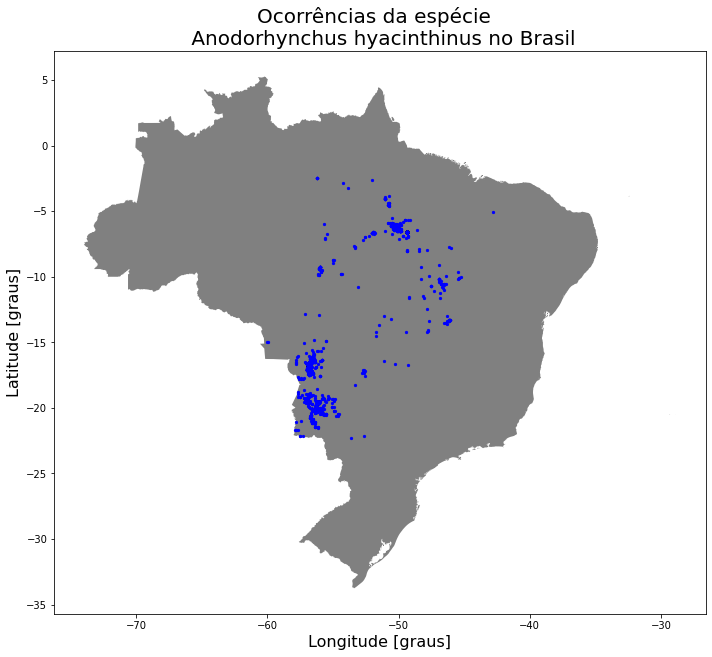

In [28]:
# presence_absence_folder_path = project_root + "/Data/Species_Presence_Absence"
brazil.plot_points_on_country(species_name=species_name,
                              map_result_path = f"{map_result_path}/{species_name_string}.png",
                              species_presences_path = f"{result_gibf_queries_data_root_folder}/{species_name_string}/{species_name_string}.shp",
                              species_absences_path=None)
  